In [1]:
import torch

In [2]:
# Mount Google Drive to save our work
from google.colab import drive
drive.mount('/content/drive')

# Create project directory
import os
project_dir = '/content/drive/MyDrive/DriverSafetySystem'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)

print(f"Working directory: {os.getcwd()}")
print(f"GPU Available: {torch.cuda.is_available()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/DriverSafetySystem
GPU Available: True


In [3]:
!pip install -q kaggle opencv-python-headless mediapipe pillow matplotlib seaborn plotly pandas numpy scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [4]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [5]:
!pip install -q timm  # PyTorch Image Models

In [6]:
!pip install -q wandb albumentations ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
import glob
from pathlib import Path
import random
import warnings
warnings.filterwarnings('ignore')

# DL
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import timm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [9]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [10]:
torch.__version__
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA L4'

In [11]:
import kagglehub

path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'driver-drowsiness-dataset-ddd' dataset.
Path to dataset files: /kaggle/input/driver-drowsiness-dataset-ddd


In [12]:
import os

dataset_path = "/content/drive/MyDrive/DriverSafetySystem"

print(os.listdir(dataset_path))

['clean_dataset', 'data_splits', 'preprocessing_config.json', 'webcam_test.py', 'WEBCAM_TEST_INSTRUCTIONS.txt', 'comprehensive_analysis.json', 'face_cropped_dataset', 'best_model_v2.pth', 'sleeping-driver-roberts-jones-1.jpg', 'sleeping-driver-roberts-jones-1 (1).jpg', 'sleeping-driver-roberts-jones-1 (2).jpg', 'man-driving-car-700x400.jpg', 'man-driving-car-700x400 (1).jpg', 'best_model.pth']


In [ ]:
# Count images
drowsy_path = os.path.join(dataset_path, "Drowsy")
non_drowsy_path = os.path.join(dataset_path, "Non Drowsy")

drowsy_images = os.listdir(drowsy_path)
non_drowsy_images = os.listdir(non_drowsy_path)
len_drowsy = len(drowsy_images)
len_non_drowsy = len(non_drowsy_images)
print(f"Drowsy images: {len_drowsy}")
print(f"Non Drowsy images: {len_non_drowsy}")
print(f"Total images: {len_drowsy +len_non_drowsy}")
print(f"\nClasses are balanced: {abs(len_drowsy - len_non_drowsy) < 100}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DriverSafetySystem/Drowsy'

In [ ]:
import matplotlib.pyplot as plt

classes = ['Drowsy', 'Non Drowsy']
counts = [len_drowsy, len_non_drowsy]

# bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=['#FF6B6B', '#4ECDC4'], edgecolor='black', linewidth=1.5)

# count labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/sum(counts)*100:.1f}%)',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Class Distribution', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Imbalance Ratio: {max(counts)/min(counts):.2f}:1")

NameError: name 'len_drowsy' is not defined

# Check for:
- Corrupted images (won't load)
- Wrong format (not jpg/png)
- Wrong dimensions (too small/large)
- Duplicates (waste training time)
- Mislabeled images (drowsy labeled as alert)

# Must do:
- Resize images to same size (e.g., 224x224)
- Normalize pixel values (0-255 → 0-1 or -1 to 1)
- Convert to RGB (if grayscale or RGBA)
- Handle different aspect ratios

# Generate variations:
- Horizontal flip
- Rotation (±15°)
- Brightness adjustment
- Zoom in/out
- Random crops

# Handle imbalance:
- Class weights
- Stratified sampling
- Proper metrics

# Must understand:
- Class distribution
- Image quality/resolution
- Lighting conditions
- Data artifacts
- Edge cases

In [ ]:
import cv2
import random
import os

#random samples
drowsy_samples = random.sample(os.listdir(drowsy_path), 8)
non_drowsy_samples = random.sample(os.listdir(non_drowsy_path), 8)

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Sample Images from Dataset', fontsize=20, fontweight='bold', y=0.98)

# Plot drowsy images (left 2 columns)
for i in range(8):
    row = i // 2
    col = i % 2

    img_path = os.path.join(drowsy_path, drowsy_samples[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Drowsy', fontsize=12, fontweight='bold', color='red')
    axes[row, col].axis('off')

# Plot non-drowsy images (right 2 columns)
for i in range(8):
    row = i // 2
    col = i % 2 + 2

    img_path = os.path.join(non_drowsy_path, non_drowsy_samples[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[row, col].imshow(img)
    axes[row, col].set_title(f'non-Drowsy', fontsize=12, fontweight='bold', color='green')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DriverSafetySystem/Drowsy'

In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 23.8 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import imagehash
import os

# Check drowsy images
print("Checking Drowsy images...")
drowsy_hashes = {}
drowsy_duplicates = 0

for img_name in os.listdir(drowsy_path):
    img = Image.open(os.path.join(drowsy_path, img_name))
    img_hash = str(imagehash.average_hash(img))

    if img_hash in drowsy_hashes:
        drowsy_duplicates += 1
    else:
        drowsy_hashes[img_hash] = img_name

# Check non-drowsy images
print("Checking Non-Drowsy images...")
non_drowsy_hashes = {}
non_drowsy_duplicates = 0

for img_name in os.listdir(non_drowsy_path):
    img = Image.open(os.path.join(non_drowsy_path, img_name))
    img_hash = str(imagehash.average_hash(img))

    if img_hash in non_drowsy_hashes:
        non_drowsy_duplicates += 1
    else:
        non_drowsy_hashes[img_hash] = img_name

print(f"Drowsy duplicates: {drowsy_duplicates}")
print(f"Non-Drowsy duplicates: {non_drowsy_duplicates}")

Checking Drowsy images...
Checking Non-Drowsy images...
Drowsy duplicates: 15122
Non-Drowsy duplicates: 13848


In [ ]:
import shutil

# Create clean dataset folder
clean_dataset_path = os.path.join(project_dir, "clean_dataset")
os.makedirs(os.path.join(clean_dataset_path, "Drowsy"), exist_ok=True)
os.makedirs(os.path.join(clean_dataset_path, "Non Drowsy"), exist_ok=True)

# Clean Drowsy images
print("Cleaning Drowsy images...")
drowsy_hashes = {}
drowsy_kept = 0

for img_name in os.listdir(drowsy_path):
    img_path = os.path.join(drowsy_path, img_name)
    img = Image.open(img_path)
    img_hash = str(imagehash.average_hash(img))

    if img_hash not in drowsy_hashes:
        # Keep this image (first occurrence)
        drowsy_hashes[img_hash] = img_name
        shutil.copy(img_path, os.path.join(clean_dataset_path, "Drowsy", img_name))
        drowsy_kept += 1

# Clean Non-Drowsy images
print("Cleaning Non-Drowsy images...")
non_drowsy_hashes = {}
non_drowsy_kept = 0

for img_name in os.listdir(non_drowsy_path):
    img_path = os.path.join(non_drowsy_path, img_name)
    img = Image.open(img_path)
    img_hash = str(imagehash.average_hash(img))

    if img_hash not in non_drowsy_hashes:
        # Keep this image
        non_drowsy_hashes[img_hash] =  img_name
        shutil.copy(img_path, os.path.join(clean_dataset_path, "Non Drowsy", img_name))
        non_drowsy_kept += 1

print(f"Location: {clean_dataset_path}")
print(f"Drowsy: {drowsy_kept} unique images (removed {len_drowsy - drowsy_kept} duplicates)")
print(f"Non-Drowsy: {non_drowsy_kept} unique images (removed {len_non_drowsy - non_drowsy_kept} duplicates)")

Cleaning Drowsy images...
Cleaning Non-Drowsy images...
Location: /content/drive/MyDrive/DriverSafetySystem/clean_dataset
Drowsy: 7226 unique images (removed 15122 duplicates)
Non-Drowsy: 5597 unique images (removed 13848 duplicates)


In [ ]:
drowsy_count = len_drowsy - drowsy_kept
non_drowsy_count = len_non_drowsy - non_drowsy_kept
total_count = drowsy_count + non_drowsy_count

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart
classes = ['Drowsy', 'Non-Drowsy']
counts = [drowsy_count, non_drowsy_count]
bars = ax1.bar(classes, counts, color=['#FF6B6B', '#4ECDC4'], edgecolor='black', linewidth=2)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/total_count*100:.1f}%)',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_title('Clean Dataset Distribution', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90,
        colors=['#FF6B6B', '#4ECDC4'], explode=(0.05, 0.05),
        shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('Class Proportion', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

NameError: name 'len_drowsy' is not defined

Analyzing...

Dimension Statistics (from 1000 images):

Width:
Min: 227px
Max: 227px
Mean: 227px
Median: 227px

Height:
Min: 227px
Max: 227px
Mean: 227px
Median: 227px

Aspect Ratio (W/H):
Min: 1.00
Max: 1.00
Mean: 1.00


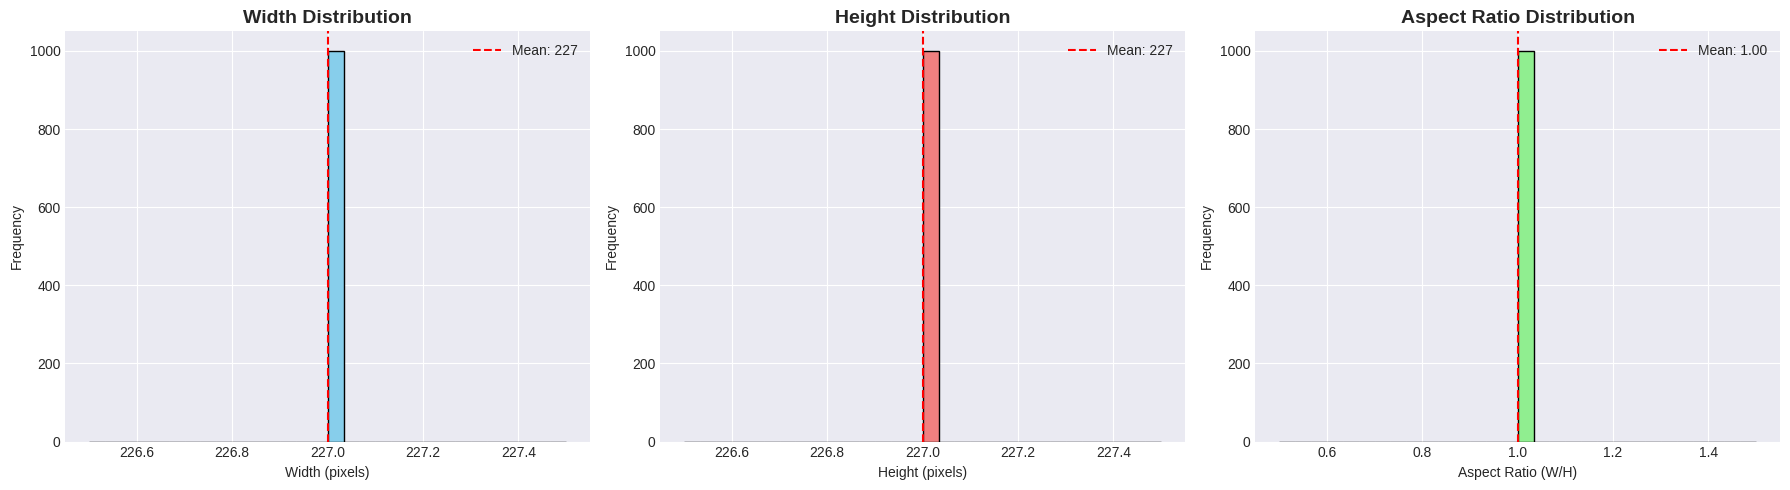

In [ ]:
# Sample 500 images from each class to analyze dimensions
drowsy_files = os.listdir(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", "Drowsy"))
non_drowsy_files = os.listdir(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", "Non Drowsy"))

sample_drowsy = random.sample(drowsy_files, min(500, len(drowsy_files)))
sample_non_drowsy = random.sample(non_drowsy_files, min(500, len(non_drowsy_files)))

widths, heights, aspect_ratios = [], [], []

print("Analyzing...\n")

for img_name in sample_drowsy + sample_non_drowsy:
    class_folder = "Drowsy" if img_name in sample_drowsy else "Non Drowsy"
    img = cv2.imread(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", class_folder, img_name))
    if img is not None:
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)

# Statistics
print(f"Dimension Statistics (from {len(widths)} images):")
print(f"\nWidth:")
print(f"Min: {min(widths)}px")
print(f"Max: {max(widths)}px")
print(f"Mean: {np.mean(widths):.0f}px")
print(f"Median: {np.median(widths):.0f}px")

print(f"\nHeight:")
print(f"Min: {min(heights)}px")
print(f"Max: {max(heights)}px")
print(f"Mean: {np.mean(heights):.0f}px")
print(f"Median: {np.median(heights):.0f}px")

print(f"\nAspect Ratio (W/H):")
print(f"Min: {min(aspect_ratios):.2f}")
print(f"Max: {max(aspect_ratios):.2f}")
print(f"Mean: {np.mean(aspect_ratios):.2f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(widths, bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Width Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
axes[0].legend()

axes[1].hist(heights, bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Height Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
axes[1].legend()

axes[2].hist(aspect_ratios, bins=30, color='lightgreen', edgecolor='black')
axes[2].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].axvline(np.mean(aspect_ratios), color='red', linestyle='--', label=f'Mean: {np.mean(aspect_ratios):.2f}')
axes[2].legend()

plt.tight_layout()
plt.show()

Pixel Statistics (from 500 images):

Brightness (Mean pixel value):
Min: 37.6
Max: 165.5
Mean: 103.0
Std: 24.7

Contrast (Std of pixel values):
Min: 24.2
Max: 99.8
Mean: 51.4
Std: 11.3


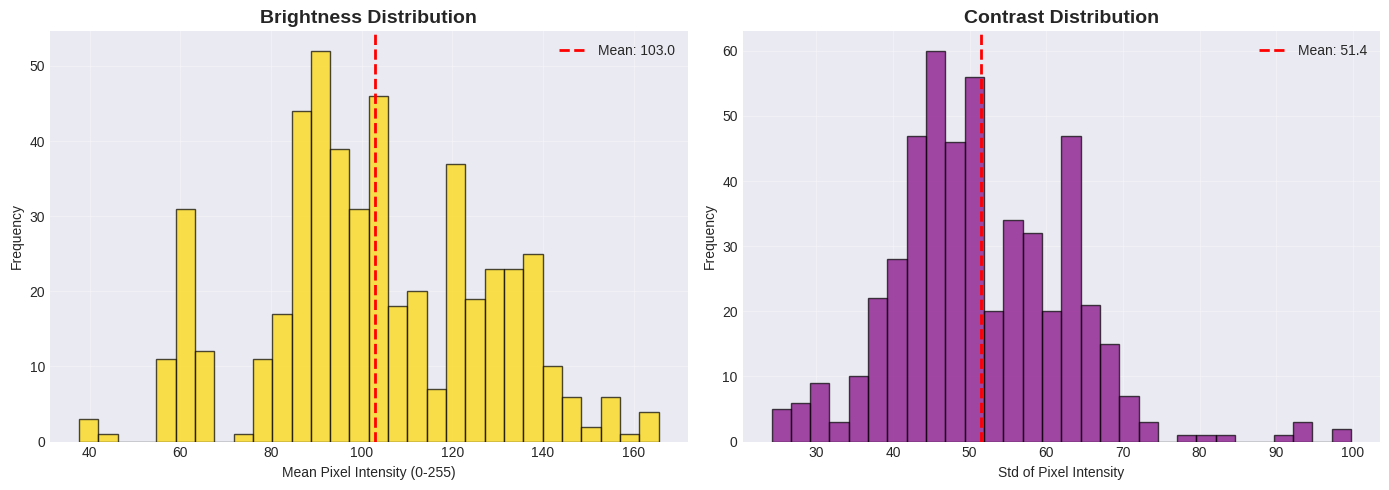

In [ ]:
brightness_vals = []
contrast_vals = []

sample_images = random.sample(drowsy_files + non_drowsy_files, 500)

for img_name in sample_images:
    class_folder = "Drowsy" if img_name in drowsy_files else "Non Drowsy"
    img = cv2.imread(os.path.join("/content/drive/MyDrive/DriverSafetySystem/clean_dataset", class_folder, img_name))
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness_vals.append(np.mean(gray))
        contrast_vals.append(np.std(gray))

print(f"Pixel Statistics (from {len(brightness_vals)} images):")
print(f"\nBrightness (Mean pixel value):")
print(f"Min: {min(brightness_vals):.1f}")
print(f"Max: {max(brightness_vals):.1f}")
print(f"Mean: {np.mean(brightness_vals):.1f}")
print(f"Std: {np.std(brightness_vals):.1f}")

print(f"\nContrast (Std of pixel values):")
print(f"Min: {min(contrast_vals):.1f}")
print(f"Max: {max(contrast_vals):.1f}")
print(f"Mean: {np.mean(contrast_vals):.1f}")
print(f"Std: {np.std(contrast_vals):.1f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(brightness_vals, bins=30, color='gold', edgecolor='black', alpha=0.7)
axes[0].set_title('Brightness Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mean Pixel Intensity (0-255)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(np.mean(brightness_vals), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(brightness_vals):.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(contrast_vals, bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[1].set_title('Contrast Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Std of Pixel Intensity')
axes[1].set_ylabel('Frequency')
axes[1].axvline(np.mean(contrast_vals), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(contrast_vals):.1f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
clean_dataset_path= "/content/drive/MyDrive/DriverSafetySystem/clean_dataset"

In [ ]:
# Get all image paths with labels
drowsy_images = [os.path.join(clean_dataset_path, "Drowsy", f)
                 for f in os.listdir(os.path.join(clean_dataset_path, "Drowsy"))]
non_drowsy_images = [os.path.join(clean_dataset_path, "Non Drowsy", f)
                     for f in os.listdir(os.path.join(clean_dataset_path, "Non Drowsy"))]

In [ ]:
# Create image paths and labels
all_images = drowsy_images + non_drowsy_images
all_labels = [0]*len(drowsy_images) + [1]*len(non_drowsy_images)  # 0=Drowsy, 1=Non-Drowsy

In [ ]:
# First split: 70% train, 30% temp (for val+test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

# Second split: Split temp into 50% val, 50% test (15% and 15% of total)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels,
    test_size=0.50,
    stratify=temp_labels,
    random_state=42
)

In [ ]:
print(f"Train: {len(train_imgs)} images ({len(train_imgs)/len(all_images)*100:.1f}%)")
print(f"Val: {len(val_imgs)} images ({len(val_imgs)/len(all_images)*100:.1f}%)")
print(f"Test: {len(test_imgs)} images ({len(test_imgs)/len(all_images)*100:.1f}%)")

print(f"\nClass distribution per split:")
print(f"Train - Drowsy: {train_labels.count(0)}, Non-Drowsy: {train_labels.count(1)}")
print(f"Val - Drowsy: {val_labels.count(0)}, Non-Drowsy: {val_labels.count(1)}")
print(f"Test - Drowsy: {test_labels.count(0)}, Non-Drowsy: {test_labels.count(1)}")

Train: 13533 images (70.0%)
Val: 2900 images (15.0%)
Test: 2900 images (15.0%)

Class distribution per split:
Train - Drowsy: 7903, Non-Drowsy: 5630
Val - Drowsy: 1694, Non-Drowsy: 1206
Test - Drowsy: 1693, Non-Drowsy: 1207


In [ ]:
# DataFrames
train_df = pd.DataFrame({'image_path': train_imgs, 'label': train_labels})
val_df = pd.DataFrame({'image_path': val_imgs, 'label': val_labels})
test_df = pd.DataFrame({'image_path': test_imgs, 'label': test_labels})

In [ ]:
# Save
splits_dir = os.path.join("/content/drive/MyDrive/DriverSafetySystem", 'data_splits')
os.makedirs(splits_dir, exist_ok=True)

train_df.to_csv(os.path.join(splits_dir, 'train.csv'), index=False)
val_df.to_csv(os.path.join(splits_dir, 'val.csv'), index=False)
test_df.to_csv(os.path.join(splits_dir, 'test.csv'), index=False)

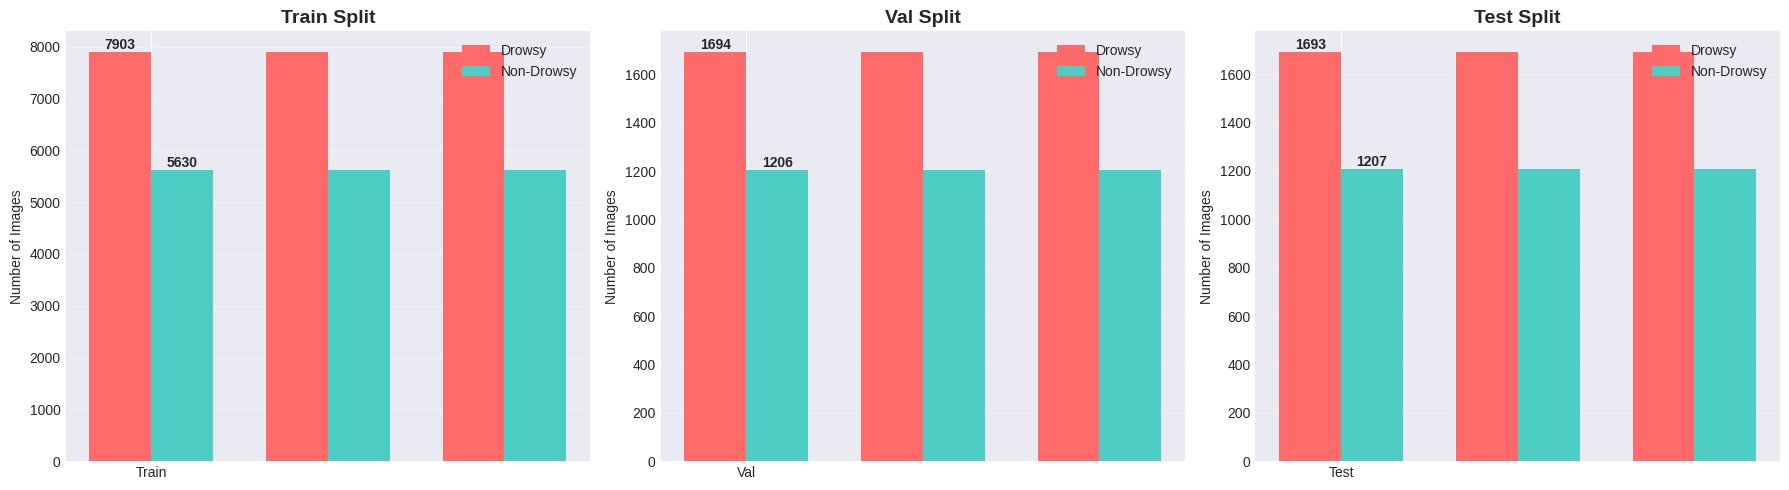

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = ['Train', 'Val', 'Test']
drowsy_counts = [train_labels.count(0), val_labels.count(0), test_labels.count(0)]
non_drowsy_counts = [train_labels.count(1), val_labels.count(1), test_labels.count(1)]

x = np.arange(len(splits))
width = 0.35

for i, ax in enumerate(axes):
    ax.bar(x - width/2, [drowsy_counts[i]], width, label='Drowsy', color='#FF6B6B')
    ax.bar(x + width/2, [non_drowsy_counts[i]], width, label='Non-Drowsy', color='#4ECDC4')
    ax.set_title(f'{splits[i]} Split', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Images')
    ax.set_xticks([0])
    ax.set_xticklabels([splits[i]])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add count labels
    ax.text(0 - width/2, drowsy_counts[i], f'{drowsy_counts[i]}',
            ha='center', va='bottom', fontweight='bold')
    ax.text(0 + width/2, non_drowsy_counts[i], f'{non_drowsy_counts[i]}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
from torchvision import transforms
# ImageNet normalization (standard for transfer learning)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [ ]:
# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
# Validation/Test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

In [ ]:
from torch.utils.data import Dataset
class DrowsinessDataset(Dataset):

    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path and label
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Create datasets
train_dataset = DrowsinessDataset(train_df, transform=train_transform)
val_dataset = DrowsinessDataset(val_df, transform=val_test_transform)
test_dataset = DrowsinessDataset(test_df, transform=val_test_transform)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

Train dataset: 13533 images
Val dataset: 2900 images
Test dataset: 2900 images


In [ ]:
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Test dataloader
sample_batch = next(iter(train_loader))
images, labels = sample_batch
print(f"Batch images shape: {images.shape}")
print(f"Batch labels shape: {labels.shape}")

Batch size: 32
Train batches: 423
Val batches: 91
Test batches: 91
Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels shape: torch.Size([32])


# Baseline Model - Eye Aspect Ratio Implementation

In [ ]:
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Eye landmark indices (MediaPipe face mesh)
LEFT_EYE_INDICES = [33, 160, 158, 133, 153, 144]
RIGHT_EYE_INDICES = [362, 385, 387, 263, 373, 380]

In [ ]:
def calculate_ear(eye_landmarks):
    A = np.linalg.norm(eye_landmarks[1] - eye_landmarks[5])
    B = np.linalg.norm(eye_landmarks[2] - eye_landmarks[4])
    C = np.linalg.norm(eye_landmarks[0] - eye_landmarks[3])
    ear = (A + B) / (2.0 * C)
    return ear

def detect_drowsiness_baseline(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if not results.multi_face_landmarks:
        return None, None

    landmarks = results.multi_face_landmarks[0].landmark
    h, w = image.shape[:2]

    # Extract eye coordinates
    left_eye = np.array([(landmarks[i].x * w, landmarks[i].y * h)
                         for i in LEFT_EYE_INDICES])
    right_eye = np.array([(landmarks[i].x * w, landmarks[i].y * h)
                          for i in RIGHT_EYE_INDICES])

    # Calculate EAR
    left_ear = calculate_ear(left_eye)
    right_ear = calculate_ear(right_eye)
    avg_ear = (left_ear + right_ear) / 2.0

    # Threshold
    EAR_THRESHOLD = 0.25
    prediction = 0 if avg_ear < EAR_THRESHOLD else 1

    return prediction, avg_ear

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Test on validation set
val_predictions = []
val_true_labels = []
val_ear_values = []
failed_detections = 0

for idx in tqdm(range(len(val_df)), desc="Evaluating baseline"):
    img_path = val_df.iloc[idx]['image_path']
    true_label = val_df.iloc[idx]['label']

    pred, ear_val = detect_drowsiness_baseline(img_path)

    if pred is not None:
        val_predictions.append(pred)
        val_true_labels.append(true_label)
        val_ear_values.append(ear_val)
    else:
        failed_detections += 1

Evaluating baseline: 100%|██████████| 2900/2900 [02:52<00:00, 16.77it/s]


Total validation images: 2900
Successfully processed: 2895
Failed detections: 5
Accuracy: 66.46%
              precision    recall  f1-score   support

      Drowsy       0.71      0.71      0.71      1689
  Non-Drowsy       0.60      0.61      0.60      1206

    accuracy                           0.66      2895
   macro avg       0.66      0.66      0.66      2895
weighted avg       0.67      0.66      0.66      2895



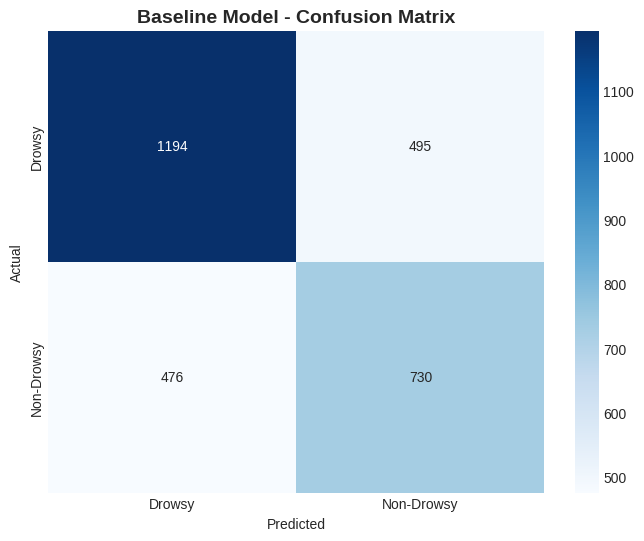

In [ ]:
#Calculate metrics
baseline_accuracy = accuracy_score(val_true_labels, val_predictions)

print(f"Total validation images: {len(val_df)}")
print(f"Successfully processed: {len(val_predictions)}")
print(f"Failed detections: {failed_detections}")
print(f"Accuracy: {baseline_accuracy*100:.2f}%")

print(classification_report(val_true_labels, val_predictions,
                           target_names=['Drowsy', 'Non-Drowsy']))

# Confusion Matrix
cm = confusion_matrix(val_true_labels, val_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Drowsy', 'Non-Drowsy'],
            yticklabels=['Drowsy', 'Non-Drowsy'])
plt.title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Setup MobileNetV2 with Transfer Learning

In [ ]:
import torch.nn as nn
import timm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Load pre-trained MobileNetV2
model = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=2)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Move model to device
model = model.to(device)

Using device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Total parameters: 2,226,434
Trainable parameters: 2,226,434


In [ ]:
from torch import optim

# Loss function with class weights (handle imbalance)
class_weights = torch.tensor([1.0, 1.29]).to(device)  # Drowsy, Non-Drowsy
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# Training hyperparameters
NUM_EPOCHS = 10
EARLY_STOPPING_PATIENCE = 3

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
import time

# Track best model
best_val_acc = 0.0
best_model_path = os.path.join("/content/drive/MyDrive/DriverSafetySystem", 'best_model.pth')
patience_counter = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Start training
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Training complete
total_time = time.time() - start_time

print(f"Total time: {total_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved: {best_model_path}")
print(f"\nBaseline accuracy: 65.85%")
print(f"MobileNetV2 accuracy: {best_val_acc:.2f}%")
print(f"Improvement: +{best_val_acc - 65.85:.2f}%")

Epoch 1/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.93it/s]


Train Loss: 0.1932 | Train Acc: 96.01%
Val Loss: 0.0111 | Val Acc: 99.59%
New best model saved! Val Acc: 99.59%
Epoch 2/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.84it/s]


Train Loss: 0.0353 | Train Acc: 98.88%
Val Loss: 0.0140 | Val Acc: 99.38%
No improvement. Patience: 1/3
Epoch 3/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.98it/s]


Train Loss: 0.0336 | Train Acc: 99.17%
Val Loss: 0.0034 | Val Acc: 99.90%
New best model saved! Val Acc: 99.90%
Epoch 4/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.93it/s]


Train Loss: 0.0594 | Train Acc: 98.59%
Val Loss: 0.0106 | Val Acc: 99.69%
No improvement. Patience: 1/3
Epoch 5/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  9.09it/s]


Train Loss: 0.0215 | Train Acc: 99.41%
Val Loss: 0.0031 | Val Acc: 99.79%
No improvement. Patience: 2/3
Epoch 6/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.98it/s]


Train Loss: 0.0114 | Train Acc: 99.71%
Val Loss: 0.0007 | Val Acc: 99.93%
New best model saved! Val Acc: 99.93%
Epoch 7/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  8.94it/s]


Train Loss: 0.0017 | Train Acc: 99.94%
Val Loss: 0.0001 | Val Acc: 100.00%
New best model saved! Val Acc: 100.00%
Epoch 8/10


Validation: 100%|██████████| 91/91 [00:09<00:00,  9.11it/s]


Train Loss: 0.0310 | Train Acc: 99.26%
Val Loss: 0.0049 | Val Acc: 99.76%
No improvement. Patience: 1/3
Epoch 9/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  9.02it/s]


Train Loss: 0.0193 | Train Acc: 99.49%
Val Loss: 0.0066 | Val Acc: 99.76%
No improvement. Patience: 2/3
Epoch 10/10


Validation: 100%|██████████| 91/91 [00:10<00:00,  9.01it/s]

Train Loss: 0.0157 | Train Acc: 99.59%
Val Loss: 0.0006 | Val Acc: 99.93%
No improvement. Patience: 3/3

Early stopping triggered after 10 epochs
Total time: 12.18 minutes
Best validation accuracy: 100.00%
Best model saved: /content/drive/MyDrive/DriverSafetySystem/best_model.pth

Baseline accuracy: 65.85%
MobileNetV2 accuracy: 100.00%
Improvement: +34.15%


In [ ]:
import cv2
import numpy as np
from scipy.spatial import distance
import time
from collections import deque
import mediapipe as mp

class DriverSafetySystem:
    """
    Multi-modal driver safety monitoring system
    Components:
    1. Drowsiness detection (temporal PERCLOS)
    2. Phone usage detection
    3. Fainting detection (>10s eye closure)
    4. Emergency alert system
    """

    def __init__(self):
        # Initialize MediaPipe
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        # Eye landmarks (MediaPipe indices)
        self.LEFT_EYE = [362, 385, 387, 263, 373, 380]
        self.RIGHT_EYE = [33, 160, 158, 133, 153, 144]

        # Temporal tracking
        self.EAR_HISTORY = deque(maxlen=90)  # 3 seconds at 30fps
        self.EAR_THRESHOLD = 0.25
        self.DROWSY_FRAMES_THRESHOLD = 27  # 30% of 90 frames
        self.FAINTING_THRESHOLD = 300  # 10 seconds at 30fps

        # State tracking
        self.consecutive_closed_frames = 0
        self.alert_status = "Normal"
        self.start_time = time.time()

        # Phone detection (placeholder - would use YOLO in production)
        self.phone_detected = False

    def calculate_ear(self, eye_landmarks):
        """Calculate Eye Aspect Ratio"""
        # Vertical distances
        A = distance.euclidean(eye_landmarks[1], eye_landmarks[5])
        B = distance.euclidean(eye_landmarks[2], eye_landmarks[4])
        # Horizontal distance
        C = distance.euclidean(eye_landmarks[0], eye_landmarks[3])

        ear = (A + B) / (2.0 * C)
        return ear

    def extract_eye_landmarks(self, face_landmarks, eye_indices, frame_shape):
        """Extract eye landmark coordinates"""
        h, w = frame_shape[:2]
        landmarks = []
        for idx in eye_indices:
            landmark = face_landmarks.landmark[idx]
            x = int(landmark.x * w)
            y = int(landmark.y * h)
            landmarks.append((x, y))
        return landmarks

    def detect_phone_usage(self, frame):
        """
        Detect phone near face
        In production: Use YOLO to detect phone object
        Placeholder: Returns False
        """
        # TODO: Implement YOLO-based phone detection
        return False

    def process_frame(self, frame):
        """
        Process single frame and return safety status
        """
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.face_mesh.process(frame_rgb)

        if not results.multi_face_landmarks:
            self.alert_status = "No Face Detected"
            return frame, self.alert_status, {}

        face_landmarks = results.multi_face_landmarks[0]

        # Extract eye landmarks
        left_eye = self.extract_eye_landmarks(
            face_landmarks, self.LEFT_EYE, frame.shape
        )
        right_eye = self.extract_eye_landmarks(
            face_landmarks, self.RIGHT_EYE, frame.shape
        )

        # Calculate EAR for both eyes
        left_ear = self.calculate_ear(left_eye)
        right_ear = self.calculate_ear(right_eye)
        avg_ear = (left_ear + right_ear) / 2.0

        # Update temporal history
        self.EAR_HISTORY.append(avg_ear)

        # Track consecutive closed frames
        if avg_ear < self.EAR_THRESHOLD:
            self.consecutive_closed_frames += 1
        else:
            self.consecutive_closed_frames = 0

        # Calculate PERCLOS (percentage of eye closure)
        if len(self.EAR_HISTORY) == 90:
            closed_frames = sum(1 for ear in self.EAR_HISTORY if ear < self.EAR_THRESHOLD)
            perclos = (closed_frames / 90) * 100
        else:
            perclos = 0

        # Determine alert status
        if self.consecutive_closed_frames > self.FAINTING_THRESHOLD:
            self.alert_status = "🚨 FAINTING DETECTED"
            alert_color = (0, 0, 255)  # Red
        elif perclos > 30:  # PERCLOS > 30% indicates drowsiness
            self.alert_status = "⚠️ DROWSY"
            alert_color = (0, 165, 255)  # Orange
        elif self.phone_detected:
            self.alert_status = "📱 PHONE USAGE"
            alert_color = (0, 255, 255)  # Yellow
        else:
            self.alert_status = "✅ ALERT"
            alert_color = (0, 255, 0)  # Green

        # Phone detection (placeholder)
        self.phone_detected = self.detect_phone_usage(frame)

        # Visualization
        # Draw eye landmarks
        for landmark in left_eye + right_eye:
            cv2.circle(frame, landmark, 2, (0, 255, 0), -1)

        # Display metrics
        metrics = {
            'EAR': avg_ear,
            'PERCLOS': perclos,
            'Closed Frames': self.consecutive_closed_frames,
            'Status': self.alert_status
        }

        # Draw status
        cv2.putText(frame, self.alert_status, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, alert_color, 2)
        cv2.putText(frame, f"EAR: {avg_ear:.3f}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"PERCLOS: {perclos:.1f}%", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        # Emergency trigger
        if self.alert_status in ["🚨 FAINTING DETECTED", "⚠️ DROWSY"]:
            cv2.rectangle(frame, (0, 0), (frame.shape[1], frame.shape[0]),
                         alert_color, 10)

        return frame, self.alert_status, metrics

print("✅ Driver Safety System initialized!")
print("\nComponents:")
print("   1. Temporal eye closure tracking (PERCLOS)")
print("   2. Fainting detection (>10s eye closure)")
print("   3. Phone usage detection (placeholder)")
print("   4. Real-time alert system")

In [ ]:
!pip install opencv-python-headless mediapipe scipy

In [ ]:
from google.colab import files
import io

print("Upload a short video of your face (5-10 seconds)")
print("Record yourself with eyes OPEN for 5 seconds")
print("Then close eyes for 3 seconds")

uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print(f"Uploaded: {video_path}")